In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Загрузка данных

In [63]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images
y = lfw_people.target

print(f'Количество изображений: {X.shape[0]}')
print(f'Размер изображений: {X.shape[1:]}')
print(f'Количество уникальных классов (лиц): {len(np.unique(y))}')


Количество изображений: 1288
Размер изображений: (50, 37)
Количество уникальных классов (лиц): 7


Выведем, что из себя представляет dataset

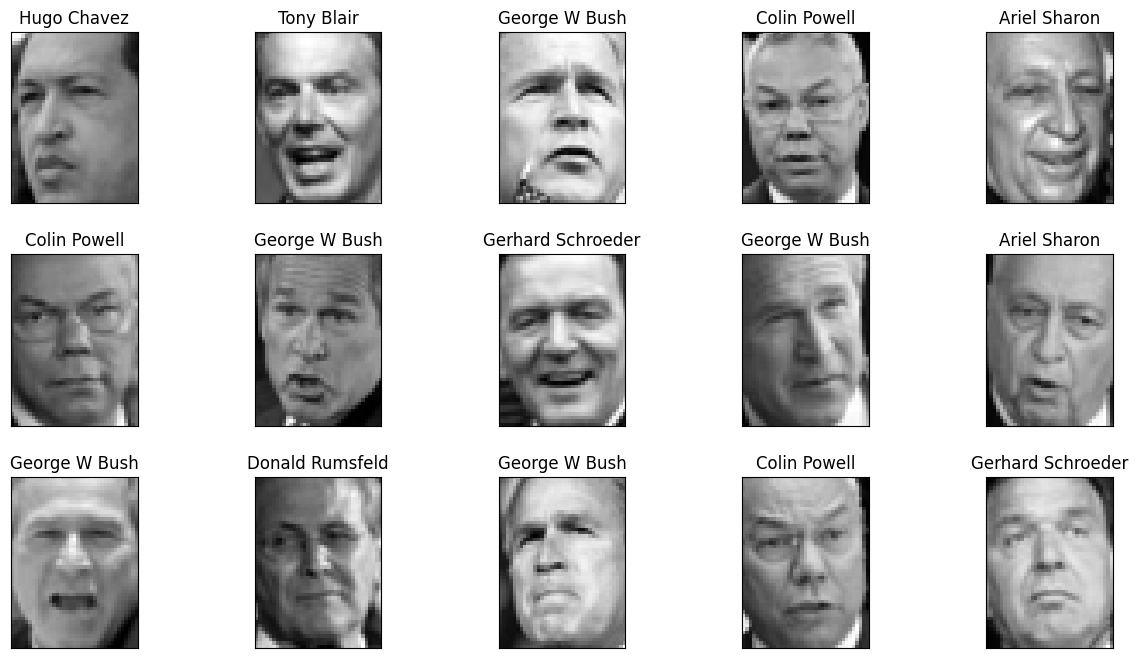

In [64]:
X = lfw_people.images
y = lfw_people.target  
target_names = lfw_people.target_names  

fig, axes = plt.subplots(3, 5, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.3, wspace=0.3))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i], cmap='gray')
    ax.set_title(target_names[y[i]])

plt.show()

Небольшая предобработка изображений

In [65]:
X = X / 255.0  # нормализация значений пикселей
X = X.reshape(-1, X.shape[1], X.shape[2], 1)  # добавляем канал для использования в Conv2D

# Преобразуем метки в one-hot формат
y = to_categorical(y)

Разделение данных на обучающую и тестовую выборки

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

Также будем использовать аугментацию данных для лучшего обобщения и улучшения устойчивости модели к различным вариациям изображения

In [67]:
# Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

Добавим подбор гиперпараметров для полносвязного слоя: количество нейронов и функцию активации

In [68]:
neurons_list = [64, 128, 256, 512]
activation_list = ['relu', 'tanh', 'sigmoid', 'elu']

In [ ]:
def create_model(neurons, activation):
    model = Sequential()
    # Первый сверточный слой
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Второй сверточный слой
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Третий сверточный слой
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Четвертый сверточный слой
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Пятый сверточный слой
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Полносвязные слой с подбором параметров
    model.add(Flatten())
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [72]:
best_accuracy = 0
best_count_neurons = 0
best_activation = ''

for count_neurons in neurons_list:
    for activation in activation_list:
        model = create_model(count_neurons, activation)
        model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=45,
                    validation_data=(X_test, y_test))
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_count_neurons = count_neurons
            best_activation = activation

        print(f'Точность на тестовых данных: {test_accuracy * 100:.2f}%')
        

Epoch 1/45


c:\Users\Vladimir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vladimir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2256 - loss: 3.3392 - val_accuracy: 0.1822 - val_loss: 1.9934
Epoch 2/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2748 - loss: 2.3096 - val_accuracy: 0.1822 - val_loss: 2.0427
Epoch 3/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3250 - loss: 1.9519 - val_accuracy: 0.1822 - val_loss: 2.1141
Epoch 4/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3533 - loss: 1.8337 - val_accuracy: 0.0891 - val_loss: 2.2414
Epoch 5/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3824 - loss: 1.7455 - val_accuracy: 0.1822 - val_loss: 2.3783
Epoch 6/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4457 - loss: 1.6136 - val_accuracy: 0.1822 - val_loss: 2.4771
Epoch 7/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4073 - loss: 1.6251 - val_accuracy: 0.1822 - val_loss: 2.5659
Epoch 8/45
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4324 - loss: 1.5961 - val_accuracy: 0.1822 - val_loss: 2.

In [73]:
print(f'Точность: {best_accuracy}')
print(f'Количество нейронов: {best_count_neurons}')
print(f'Функция активации: {best_activation}')

Точность: 0.8255813717842102
Количество нейронов: 128
Функция активации: sigmoid
